In [29]:
import numpy as np
import pandas as pd
import os
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from itertools import product, combinations
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import HuberRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
from numpy.random import rand
from tensorflow.keras.models import load_model
from os.path import exists
from itertools import chain

# Meta

In [30]:
def extract_numeric(value):
    if pd.isna(value):
        return None
    # Ensure the input is treated as a string
    value = str(value)
    numeric_part = re.findall(r"[\d\.]+", value)
    return float(numeric_part[0]) if numeric_part else None

In [31]:
def train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, feature_name, metal="Aluminum", no_sort = False):
    """
    Trains a Random Forest regressor, evaluates it, plots feature importances,
    and generates a LaTeX figure caption, with the ability to specify the target feature name.

    Parameters:
        X_train (DataFrame): Training data features.
        y_train (Series): Training data target.
        X_test (DataFrame): Test data features.
        y_test (Series): Test data target.
        output_dir (str): Directory to save output files.
        feature_name (str): The name of the target feature to use in titles and labels.
    """
    if output_dir is not None:
        # Ensure the output directory exists
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    # Initialize the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    rf_predictions = rf_model.predict(X_test)

    # Calculate the mean squared error
    rf_mse = mean_squared_error(y_test, rf_predictions)

    # Get feature importances from the Random Forest model
    rf_feature_importances = rf_model.feature_importances_

    if no_sort:
        # Create a DataFrame for better visualization of feature importances
        features_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': rf_feature_importances
        })
    else:
        # Create a DataFrame for better visualization of feature importances
        features_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': rf_feature_importances
        }).sort_values(by='Importance', ascending=False)

    if output_dir is not None:
        # Plot feature importances
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=features_importance_df, color='blue')
        plt.title(f'Feature Importances in Predicting {feature_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plot_path = os.path.join(output_dir, f'{metal}_{feature_name.replace(" ", "_")}_RandomForestFeatureImportance.png')
        plt.savefig(plot_path)
        plt.show()

        # LaTeX code for the figure
        latex_code = rf"""
        \begin{{figure}}[h]
            \centering
            \includegraphics[width=0.8\textwidth]{{{plot_path}}}
            \caption{{Random Forest Feature Importance for predicting {feature_name}}}
            \label{{fig:{metal}_{feature_name.replace(" ", "_")}_RandomForestFeatureImportance}}
        \end{{figure}}
        """
        latex_file_path = os.path.join(output_dir, f'{metal}_{feature_name.replace(" ", "_")}_RandomForestFeatureImportance.tex')
        with open(latex_file_path, 'w') as f:
            f.write(latex_code)

    return rf_mse, features_importance_df

In [32]:
#file_path = 'Aldf.csv'
file_path = 'Combodf.csv'
output_dir = None # if output dir is None, no plot is generated or saved

metals = ['Aluminum', 'Nickel', 'Titanium']
# Property names corresponding to min_values and max_values
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']
count = 0
rf_mse = []
#rf_mse2 = []
features_importance_df = []
s_metal = []
s_prop =[]
for metal in metals:
    for p_name in property_names:
        df = pd.read_csv(file_path)
        df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"}) # make this element name shorter to match length of others
        # Filter the DataFrame where 'type' is 'a'
        df = df[df['Metal Type'] == metal]
        df = df.drop('Metal Type', axis=1)
        
        # Assuming df1 is your DataFrame and it contains the columns 'Tensile Strength'
        df[p_name] = df[p_name].apply(extract_numeric)

        # List all columns to keep (metal percentages and Tensile Strength)
        columns_to_keep = [p_name] + [col for col in df.columns if ',' in col]

        # Create a new dataframe with only these columns
        metals_and_tensile = df[columns_to_keep]

        # Check for missing values in the new dataset
        missing_values_metals = metals_and_tensile.isnull().sum()
        missing_values_metals[missing_values_metals > 0], metals_and_tensile.head()
        # Splitting the dataset into features and target variable
        X = metals_and_tensile.drop(p_name, axis=1)
        y = metals_and_tensile[p_name]

        # Splitting data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train.head(), y_train.head()


        print("X_train shape:", X_train.shape)
        print("y_train shape:", y_train.shape)
        print("X_test shape:", X_test.shape)
        print("y_test shape:", y_test.shape)

        mse, feature_df = train_and_evaluate_simple_rf(X_train, y_train, X_test, y_test, output_dir, p_name, metal=metal,no_sort=True)


        #rf_mse2.append(np.sqrt(mse)/np.std(y_test))
        rf_mse.append(np.sqrt(mse)/np.sqrt(np.sum((y_test-np.mean(y_train))**2)/len(y_test)))
        features_importance_df.append(feature_df)
        s_metal.append(metal)
        s_prop.append(p_name)

        print(feature_df)


# Normalize and concatenate all feature importance DataFrames
# Create a dictionary to hold normalized DataFrames
normalized_dfs = {}
for i, fi_df in enumerate(features_importance_df):
    column_name = f"{s_metal[i]}_{s_prop[i]}"
    normalized_dfs[column_name] = fi_df['Importance']

# Concatenate all normalized DataFrames along the columns
final_df = pd.concat(normalized_dfs, axis=1)

X_train shape: (395, 34)
y_train shape: (395,)
X_test shape: (99, 34)
y_test shape: (99,)
           Feature    Importance
0     Aluminum, Al  6.402052e-01
1     Chromium, Cr  5.300683e-03
2       Copper, Cu  2.884079e-02
3         Iron, Fe  1.323620e-02
4    Magnesium, Mg  4.728964e-02
5    Manganese, Mn  9.934670e-03
6      Silicon, Si  1.353793e-01
7     Titanium, Ti  1.442784e-02
8         Zinc, Zn  4.746069e-02
9    Zirconium, Zr  1.442303e-03
10     Vanadium, V  7.908834e-04
11        Boron, B  2.226348e-06
12      Nickel, Ni  1.147280e-02
13     Gallium, Ga  3.976887e-07
14       Oxygen, O  0.000000e+00
15   Beryllium, Be  1.369232e-05
16     Bismuth, Bi  5.584677e-03
17        Lead, Pb  9.237655e-04
18         Tin, Sn  3.810935e-03
19    Scandium, Sc  0.000000e+00
20     Lithium, Li  3.288616e-02
21      Silver, Ag  9.970845e-04
22       Carbon, C  0.000000e+00
23      Cobalt, Co  0.000000e+00
24  Molybdenum, Mo  0.000000e+00
25     Niobium, Nb  0.000000e+00
26   Phosphorus, P 

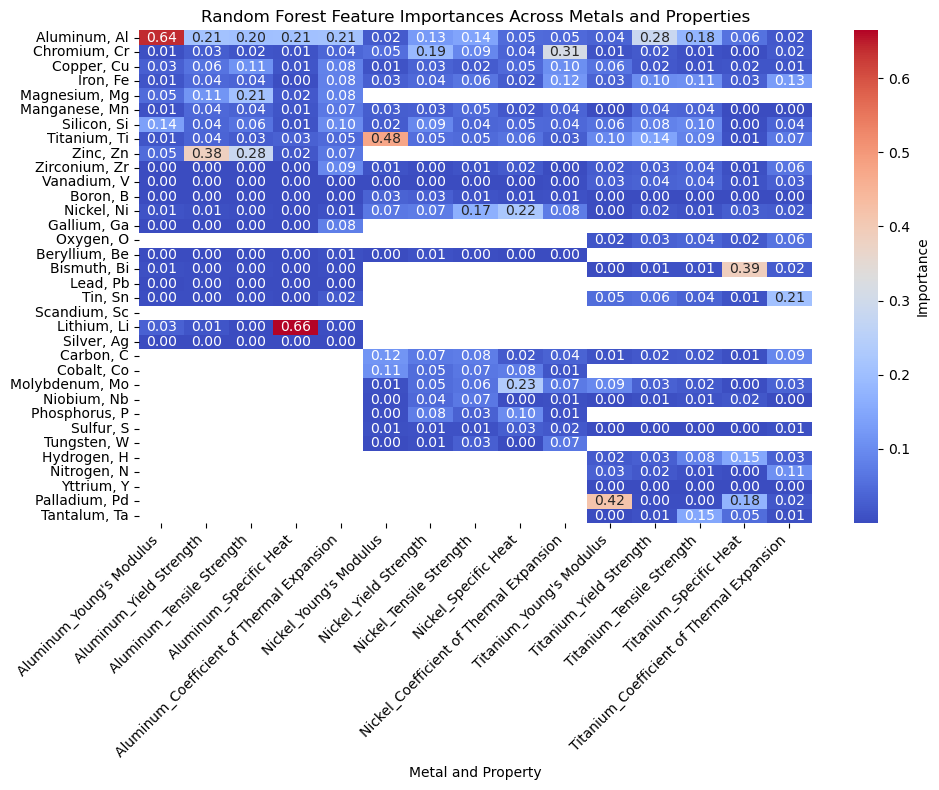

In [33]:
# Assuming 'final_df' is the DataFrame from the previous code snippet
final_df[final_df==0]=np.NaN # true zeros are actual because the feature had no data, convert to NaN
# Create a heatmap
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
sns.heatmap(final_df, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Importance'})
plt.title('Random Forest Feature Importances Across Metals and Properties')
plt.xlabel('Metal and Property')
ytick_positions = np.arange(len(fi_df['Feature'])) + 0.5  # Shift positions slightly downwards
plt.yticks(ytick_positions, fi_df['Feature'])

plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.yticks(rotation=0)  # Keep y-labels horizontal
plt.tight_layout()  # Adjust subplot parameters for a better fit into the figure area
plt.savefig("Images/Meta/MetalsandProperties")
# Show the plot
plt.show()

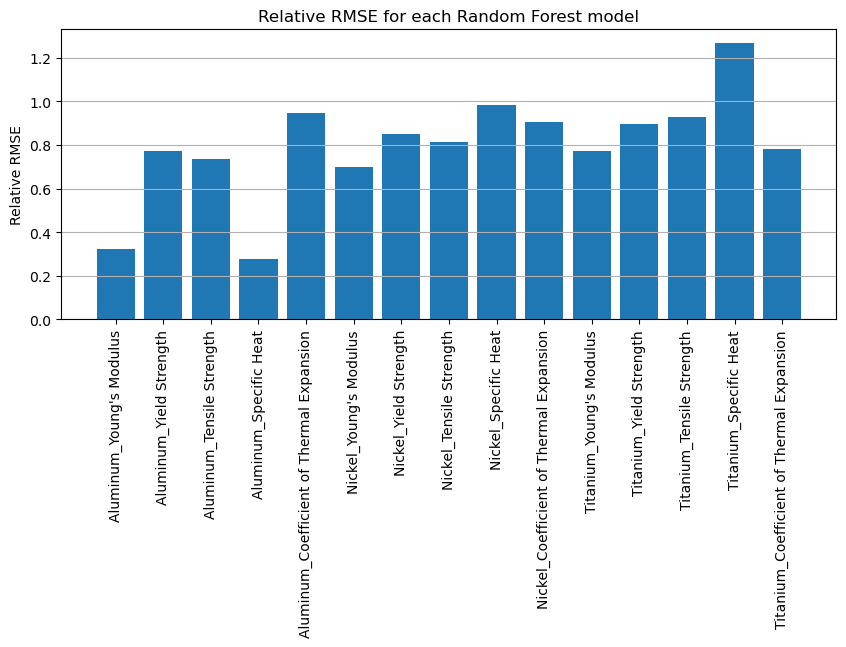

In [34]:
features = final_df.columns
plt.figure(figsize=(10, 5))
plt.bar(features, rf_mse)
plt.ylabel('Relative RMSE')
plt.xticks(rotation='vertical')  # Rotate x-axis labels for better readability
plt.title('Relative RMSE for each Random Forest model')
plt.grid(axis='y') 

# Adjust the bottom margin to make room for vertical x-axis labels
plt.subplots_adjust(bottom=0.3)  # Increase this value if labels are still cut off

# Save the figure with enough margin to include all elements, especially the labels
plt.savefig("Images/Meta/RandomForestModels.png", bbox_inches='tight')

# Display the plot
plt.show()

In [35]:
df.describe()

Density  Young's Modulus  Yield Strength  Tensile Strength  \
count  201.000000       201.000000      201.000000        201.000000   
mean     4.679449         0.092125       -0.102158         -0.063506   
std      0.268125         0.868875        0.874612          0.853089   
min      4.360000        -5.181945       -2.459420         -2.484536   
25%      4.540000        -0.101843       -0.273891         -0.221990   
50%      4.642600         0.222419        0.062025          0.102942   
75%      4.718131         0.605216        0.357418          0.356129   
max      6.450000         1.033073        1.860532          1.643757   

       Specific Heat  Coefficient of Thermal Expansion  Aluminum, Al  \
count   2.010000e+02                        201.000000    201.000000   
mean    4.418798e-17                          0.732087      4.835625   
std     1.002497e+00                          0.682913      2.126965   
min    -5.771853e+00                          0.003696      0.000000   
25%    -2.321944e-01                          0.338272      3.000000   
50%     5.431620e-02                          0.566658      5.931800   
75%     1.999704e-01                          0.840015      6.339500   
max     4.423943e+00                          4.866242      8.350000   

       Chromium, Cr  Copper, Cu    Iron, Fe  ...  Molybdenum, Mo  Niobium, Nb  \
count    201.000000  201.000000  201.000000  ...      201.000000   201.000000   
mean       2.363627    0.085436    0.401771  ...        2.064401     0.067861   
std        2.958976    0.213253    0.390165  ...        2.333874     0.344366   
min        0.000000    0.000000    0.000000  ...        0.000000     0.000000   
25%        0.000000    0.000000    0.250000  ...        0.355500     0.000000   
50%        0.100000    0.005000    0.336500  ...        1.854000     0.000000   
75%        5.748900    0.153095    0.379338  ...        2.683015     0.000000   
max       11.000000    2.000000    2.000000  ...       15.000000     2.000000   

       Phosphorus, P   Sulfur, S  Tungsten, W  Hydrogen, H  Nitrogen, N  \
count          201.0  201.000000        201.0   201.000000   201.000000   
mean             0.0    0.000358          0.0     0.010864     0.070067   
std              0.0    0.001699          0.0     0.012147     0.058856   
min              0.0    0.000000          0.0     0.000000     0.000000   
25%              0.0    0.000000          0.0     0.005037     0.040000   
50%              0.0    0.000000          0.0     0.013000     0.050000   
75%              0.0    0.000066          0.0     0.014955     0.146197   
max              0.0    0.010000          0.0     0.100000     0.400000   

       Yttrium, Y  Palladium, Pd  Tantalum, Ta  
count  201.000000     201.000000    201.000000  
mean     0.000249       0.003812      0.190927  
std      0.001090       0.022568      2.123710  
min      0.000000       0.000000      0.000000  
25%      0.000000       0.000000      0.000000  
50%      0.000000       0.000000      0.000000  
75%      0.000000       0.000000      0.000100  
max      0.005000       0.150000     30.000000  

[8 rows x 40 columns]

In [36]:
file_path = 'Combodf.csv'
corr_dict = {}
prev=None
metals = ['Aluminum', 'Nickel', 'Titanium']
# Property names corresponding to min_values and max_values
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']
for metal in metals:
    df = pd.read_csv(file_path)
    df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"}) # make this element name shorter to match length of others
    df = df[df['Metal Type'] == metal] # keep only this metal
    df = df.drop('Metal Type', axis=1)
    df = df.drop('Density', axis=1)
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    for p_name in property_names:
        # Isolate the correlation of the target feature with other features
        target_corr = corr_matrix[p_name]
        for drop_p_name in property_names:
            target_corr = target_corr.drop(drop_p_name)
        corr_dict[metal+" "+target_corr.name] = target_corr.values
        if prev is not None: # double check that the elements are in the same order
            if target_corr.index != prev:
                print('error')
            prev = target_corr.index


In [37]:
corr_df = pd.DataFrame(corr_dict)

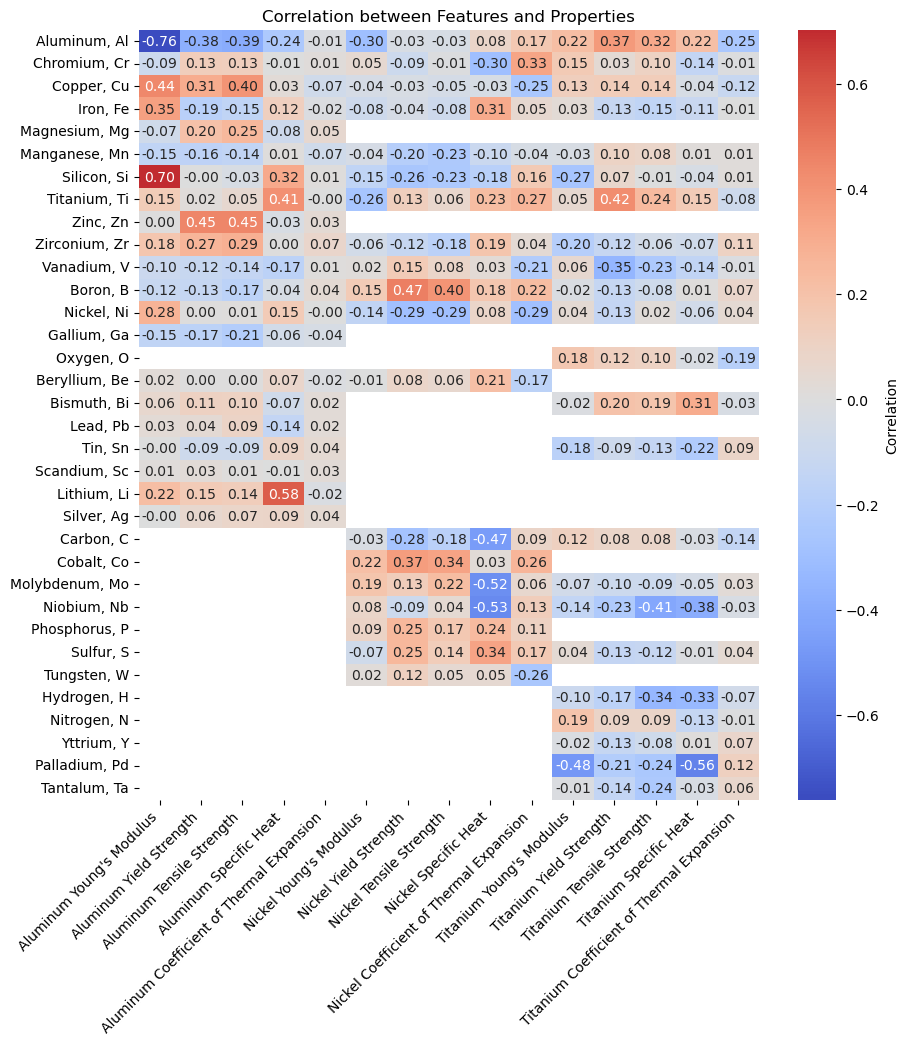

In [38]:
plt.figure(figsize=(10, 10))
plt.title('Correlation between Features and Properties')
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", cbar_kws={'label': 'Correlation'})
plt.yticks( np.arange(0.5,len(target_corr.index)+.5),target_corr.index)
plt.yticks(rotation=0)  # Keep y-labels horizontal
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.savefig("Images/Meta/CorrelationFeaturesProperties")
plt.show()

In [39]:
# Paths to all uploaded files
file_paths_2v = {
    'Aluminum_modulus': 'Al_model_data/mse_scores_with_aluminum_2_features_modulus.csv',
    'Aluminum_yield': 'Al_model_data/mse_scores_with_aluminum_2_features_yield.csv',
    'Aluminum_tensile': 'Al_model_data/mse_scores_with_aluminum_2_features_tensile.csv',
    'Aluminum_heat': 'Al_model_data/mse_scores_with_aluminum_2_features_heat.csv',
    'Aluminum_COTE': 'Al_model_data/mse_scores_with_aluminum_2_features_COTE.csv',
    'Nickel_modulus': 'Ni_model_data/mse_scores_with_nickel_2_features_modulus.csv',
    'Nickel_yield': 'Ni_model_data/mse_scores_with_nickel_2_features_yield.csv',
    'Nickel_tensile': 'Ni_model_data/mse_scores_with_nickel_2_features_tensile.csv',
    'Nickel_heat': 'Ni_model_data/mse_scores_with_nickel_2_features_heat.csv',
    'Nickel_COTE': 'Ni_model_data/mse_scores_with_nickel_2_features_COTE.csv',
    'Titanium_modulus': 'Ti_model_data/mse_scores_with_titanium_2_features_modulus.csv',
    'Titanium_yield': 'Ti_model_data/mse_scores_with_titanium_2_features_yield.csv',
    'Titanium_tensile': 'Ti_model_data/mse_scores_with_titanium_2_features_tensile.csv',
    'Titanium_heat': 'Ti_model_data/mse_scores_with_titanium_2_features_heat.csv',
    'Titanium_COTE': 'Ti_model_data/mse_scores_with_titanium_2_features_COTE.csv'
}

file_paths_3v = {
    'Aluminum_modulus': 'Al_model_data/mse_scores_with_aluminum_3_features_modulus.csv',
    'Aluminum_yield': 'Al_model_data/mse_scores_with_aluminum_3_features_yield.csv',
    'Aluminum_tensile': 'Al_model_data/mse_scores_with_aluminum_3_features_tensile.csv',
    'Aluminum_heat': 'Al_model_data/mse_scores_with_aluminum_3_features_heat.csv',
    'Aluminum_COTE': 'Al_model_data/mse_scores_with_aluminum_3_features_COTE.csv',
    'Nickel_modulus': 'Ni_model_data/mse_scores_with_nickel_3_features_modulus.csv',
    'Nickel_yield': 'Ni_model_data/mse_scores_with_nickel_3_features_yield.csv',
    'Nickel_tensile': 'Ni_model_data/mse_scores_with_nickel_3_features_tensile.csv',
    'Nickel_heat': 'Ni_model_data/mse_scores_with_nickel_3_features_heat.csv',
    'Nickel_COTE': 'Ni_model_data/mse_scores_with_nickel_3_features_COTE.csv',
    'Titanium_modulus': 'Ti_model_data/mse_scores_with_titanium_3_features_modulus.csv',
    'Titanium_yield': 'Ti_model_data/mse_scores_with_titanium_3_features_yield.csv',
    'Titanium_tensile': 'Ti_model_data/mse_scores_with_titanium_3_features_tensile.csv',
    'Titanium_heat': 'Ti_model_data/mse_scores_with_titanium_3_features_heat.csv',
    'Titanium_COTE': 'Ti_model_data/mse_scores_with_titanium_3_features_COTE.csv'
}


# Function to find the best-performing combinations
def find_best_combinations(file_paths):
    best_combinations = {}
    for key, path in file_paths.items():
        data = pd.read_csv(path)
        best_combinations[key] = data.loc[data['MSE'].idxmin()]
    return best_combinations

# Get best combinations for 2-variable and 3-variable models
best_combinations_2v = find_best_combinations(file_paths_2v)
best_combinations_3v = find_best_combinations(file_paths_3v)

best_combinations_2v, best_combinations_3v


({'Aluminum_modulus': Combination    ('Silicon, Si', 'Aluminum, Al')
  MSE                                    0.36651
  Name: 0, dtype: object,
  'Aluminum_yield': Combination    ('Titanium, Ti', 'Aluminum, Al')
  MSE                                    0.408951
  Name: 7, dtype: object,
  'Aluminum_tensile': Combination    ('Iron, Fe', 'Aluminum, Al')
  MSE                                0.368956
  Name: 2, dtype: object,
  'Aluminum_heat': Combination    ('Lead, Pb', 'Aluminum, Al')
  MSE                                0.719781
  Name: 14, dtype: object,
  'Aluminum_COTE': Combination    ('Lead, Pb', 'Aluminum, Al')
  MSE                                0.567225
  Name: 14, dtype: object,
  'Nickel_modulus': Combination    ('Molybdenum, Mo', 'Nickel, Ni')
  MSE                                     0.33895
  Name: 4, dtype: object,
  'Nickel_yield': Combination    ('Niobium, Nb (Columbium, Cb)', 'Nickel, Ni')
  MSE                                                 0.522221
  Name: 5, dtype

In [40]:
# Helper function to parse combinations from string
def parse_combinations(combination_series):
    return [tuple(eval(comb)) for comb in combination_series]

# Gather all feature combinations
features_2v = chain.from_iterable(parse_combinations(pd.Series({k: v['Combination'] for k, v in best_combinations_2v.items()})))
features_3v = chain.from_iterable(parse_combinations(pd.Series({k: v['Combination'] for k, v in best_combinations_3v.items()})))

# Count occurrences of each feature in 2V and 3V models
from collections import Counter

counter_2v = Counter(features_2v)
counter_3v = Counter(features_3v)

# Create matrix of selections
all_features = set(counter_2v.keys()).union(set(counter_3v.keys()))
feature_matrix = {feature: [counter_2v.get(feature, 0), counter_3v.get(feature, 0)] for feature in all_features}

# Convert counts to the encoding (0, 1, 2, 3)
for feature, counts in feature_matrix.items():
    encode = (1 if counts[0] > 0 else 0) + (2 if counts[1] > 0 else 0)
    feature_matrix[feature] = encode

# Create a DataFrame from the matrix
import numpy as np
features_df = pd.DataFrame(list(feature_matrix.items()), columns=['Feature', 'Selection Code']).sort_values('Feature')
features_df.set_index('Feature', inplace=True)
features_df.T # Transpose for desired format


Feature         Aluminum, Al  Boron, B  Chromium, Cr  Cobalt, Co  Iron, Fe  \
Selection Code             3         2             3           3         3   

Feature         Lead, Pb  Lithium, Li  Magnesium, Mg  Manganese, Mn  \
Selection Code         1            2              2              2   

Feature         Molybdenum, Mo  Nickel, Ni  Niobium, Nb (Columbium, Cb)  \
Selection Code               3           3                            1   

Feature         Palladium, Pd  Phosphorus, P  Silicon, Si  Tin, Sn  \
Selection Code              2              2            3        1   

Feature         Titanium, Ti  Zinc, Zn  Zirconium, Zr  
Selection Code             3         2              2

/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_83042/2174556882.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(properties, rotation=45)
/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_83042/2174556882.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(properties, rotation=45)


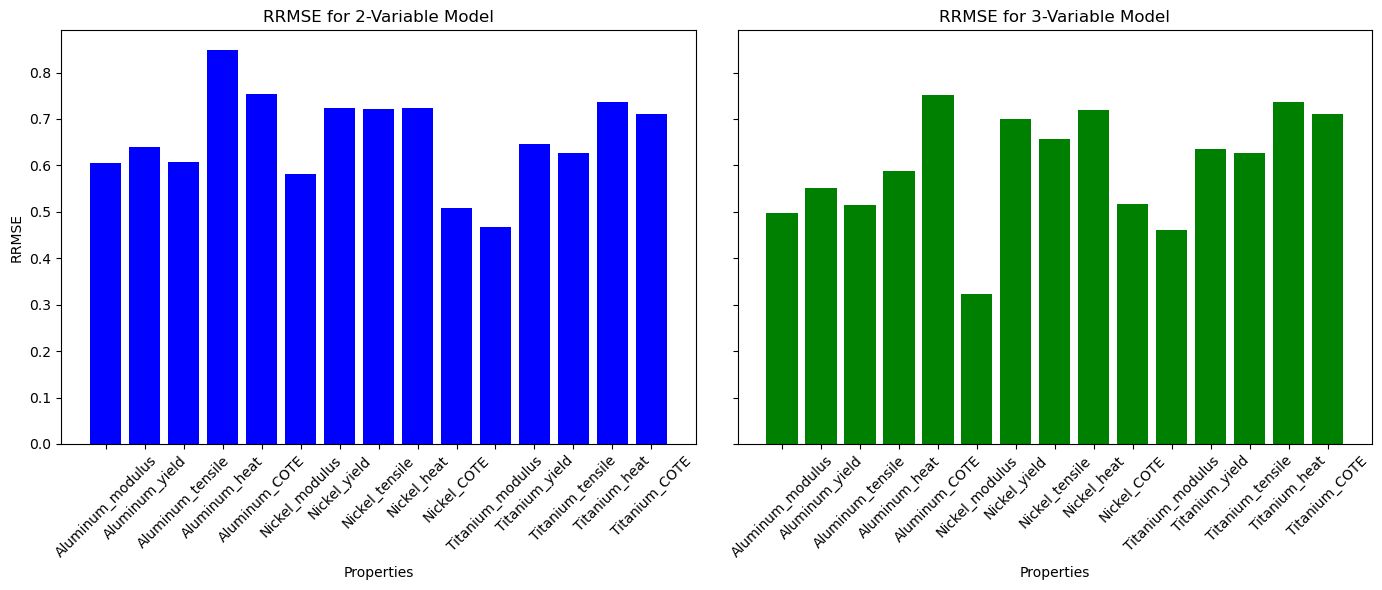

/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_83042/2174556882.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(properties, rotation=45, ha='right')
/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_83042/2174556882.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(properties, rotation=45, ha='right')


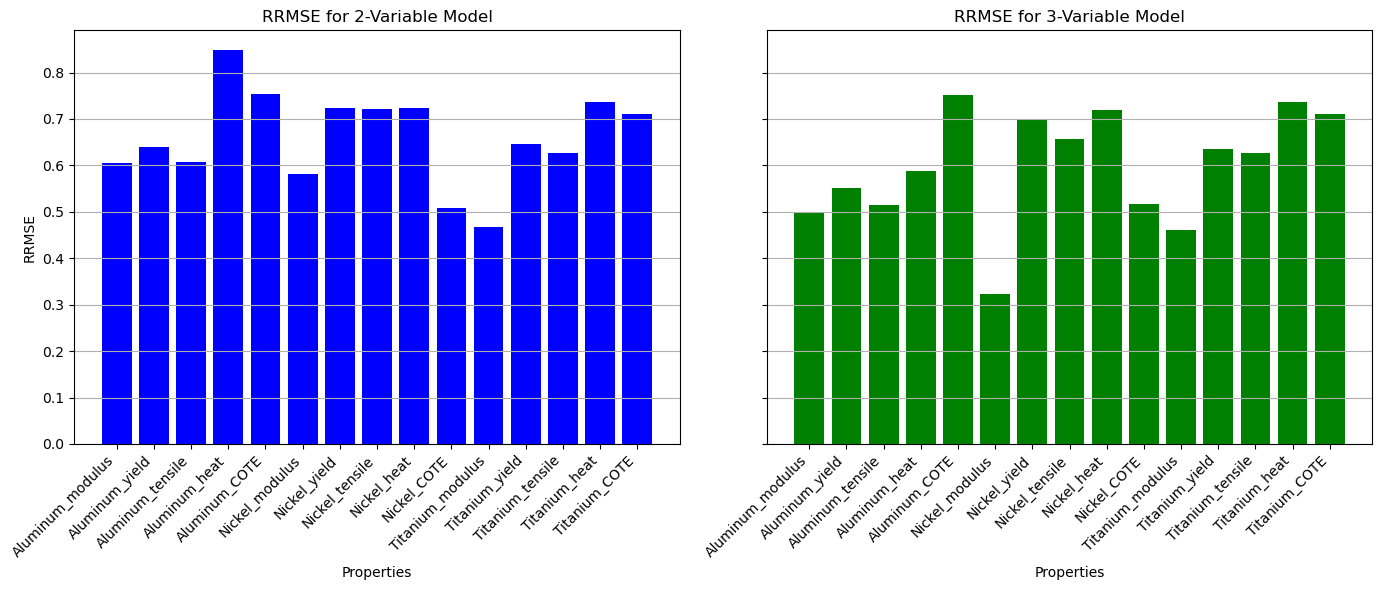

In [41]:
import matplotlib.pyplot as plt

# Compute RRMSE from MSE by taking the square root (as a simple approach to demonstrate)
# Typically RRMSE is relative to some benchmark which isn't provided, so we'll assume RRMSE = sqrt(MSE) for visualization
properties = list(best_combinations_2v.keys())
rrmse_2v = [best_combinations_2v[prop]['MSE']**0.5 for prop in properties]
rrmse_3v = [best_combinations_3v[prop]['MSE']**0.5 for prop in properties]

# Plotting the RRMSE for 2-variable and 3-variable models
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax[0].bar(properties, rrmse_2v, color='blue')
ax[0].set_title('RRMSE for 2-Variable Model')
ax[0].set_ylabel('RRMSE')
ax[0].set_xlabel('Properties')
ax[0].set_xticklabels(properties, rotation=45)

ax[1].bar(properties, rrmse_3v, color='green')
ax[1].set_title('RRMSE for 3-Variable Model')
ax[1].set_xlabel('Properties')
ax[1].set_xticklabels(properties, rotation=45)

plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt

# Compute RRMSE from MSE by taking the square root (as a simple approach to demonstrate)
# Typically RRMSE is relative to some benchmark which isn't provided, so we'll assume RRMSE = sqrt(MSE) for visualization
properties = list(best_combinations_2v.keys())
rrmse_2v = [best_combinations_2v[prop]['MSE']**0.5 for prop in properties]
rrmse_3v = [best_combinations_3v[prop]['MSE']**0.5 for prop in properties]

# Plotting the RRMSE for 2-variable and 3-variable models
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


# Plot for the first subplot
ax[0].bar(properties, rrmse_2v, color='blue')
ax[0].set_title('RRMSE for 2-Variable Model')
ax[0].set_ylabel('RRMSE')
ax[0].set_xlabel('Properties')
ax[0].set_xticklabels(properties, rotation=45, ha='right')
ax[0].grid(axis='y')  # Add gridlines along the y-axis

# Plot for the second subplot
ax[1].bar(properties, rrmse_3v, color='green')
ax[1].set_title('RRMSE for 3-Variable Model')
ax[1].set_xlabel('Properties')
ax[1].set_xticklabels(properties, rotation=45, ha='right')
ax[1].grid(axis='y')  # Add gridlines along the y-axis

plt.tight_layout()
plt.show()



In [42]:
# Creating a table that includes all elements as rows and properties as columns
# Initialize an empty DataFrame with all features as index and properties as columns
property_matrix = pd.DataFrame(index=list(all_features), columns=properties, data=0)

# Update the DataFrame with encoded values
for prop in properties:
    combination_2v = set(parse_combinations([best_combinations_2v[prop]['Combination']])[0])
    combination_3v = set(parse_combinations([best_combinations_3v[prop]['Combination']])[0])
    for feature in combination_2v:
        property_matrix.at[feature, prop] = 1  # Mark feature selected by 2V
    for feature in combination_3v:
        property_matrix.at[feature, prop] += 2  # Add 2 if selected by 3V, making it 3 if already selected by 2V

property_matrix.T  # Transpose for the requested format (features as rows)


Lead, Pb  Molybdenum, Mo  Lithium, Li  Manganese, Mn  \
Aluminum_modulus         0               0            0              0   
Aluminum_yield           0               0            0              2   
Aluminum_tensile         0               0            0              0   
Aluminum_heat            1               0            2              0   
Aluminum_COTE            1               0            0              0   
Nickel_modulus           0               1            0              0   
Nickel_yield             0               0            0              0   
Nickel_tensile           0               0            0              2   
Nickel_heat              0               0            0              0   
Nickel_COTE              0               0            0              0   
Titanium_modulus         0               1            0              0   
Titanium_yield           0               0            0              0   
Titanium_tensile         0               1            0              0   
Titanium_heat            0               0            0              0   
Titanium_COTE            0               2            0              0   

                  Phosphorus, P  Palladium, Pd  Nickel, Ni  Tin, Sn  \
Aluminum_modulus              0              0           0        0   
Aluminum_yield                0              0           0        0   
Aluminum_tensile              0              0           0        0   
Aluminum_heat                 0              0           0        0   
Aluminum_COTE                 0              0           0        0   
Nickel_modulus                0              0           3        0   
Nickel_yield                  0              0           3        0   
Nickel_tensile                0              0           3        0   
Nickel_heat                   2              0           3        0   
Nickel_COTE                   0              0           3        0   
Titanium_modulus              0              0           0        0   
Titanium_yield                0              0           0        0   
Titanium_tensile              0              2           0        0   
Titanium_heat                 0              0           0        0   
Titanium_COTE                 0              0           0        1   

                  Chromium, Cr  Iron, Fe  Zinc, Zn  Cobalt, Co  Silicon, Si  \
Aluminum_modulus             0         0         2           0            3   
Aluminum_yield               0         0         2           0            0   
Aluminum_tensile             0         1         2           0            0   
Aluminum_heat                0         0         0           0            0   
Aluminum_COTE                0         0         2           0            0   
Nickel_modulus               0         0         0           2            0   
Nickel_yield                 0         0         0           2            0   
Nickel_tensile               0         0         0           2            0   
Nickel_heat                  1         0         0           2            0   
Nickel_COTE                  2         0         0           1            2   
Titanium_modulus             0         0         0           0            2   
Titanium_yield               1         2         0           0            0   
Titanium_tensile             0         0         0           0            2   
Titanium_heat                3         0         0           0            0   
Titanium_COTE                2         0         0           0            0   

                  Niobium, Nb (Columbium, Cb)  Boron, B  Zirconium, Zr  \
Aluminum_modulus                            0         0              0   
Aluminum_yield                              0         0              0   
Aluminum_tensile                            0         0              0   
Aluminum_heat                               0         0              0   
Aluminum_COTE                               0         0      

In [43]:
# List of all elements provided
all_elements = [
    "Aluminum, Al", "Chromium, Cr", "Copper, Cu", "Iron, Fe", "Magnesium, Mg",
    "Manganese, Mn", "Silicon, Si", "Titanium, Ti", "Zinc, Zn", "Zirconium, Zr",
    "Vanadium, V", "Boron, B", "Nickel, Ni", "Gallium, Ga", "Oxygen, O",
    "Beryllium, Be", "Bismuth, Bi", "Lead, Pb", "Tin, Sn", "Scandium, Sc",
    "Lithium, Li", "Silver, Ag", "Carbon, C", "Cobalt, Co", "Molybdenum, Mo",
    "Niobium, Nb", "Phosphorus, P", "Sulfur, S", "Tungsten, W", "Hydrogen, H",
    "Nitrogen, N", "Yttrium, Y", "Palladium, Pd", "Tantalum, Ta"
]

# Create a new DataFrame initialized with zeros
full_property_matrix = pd.DataFrame(index=all_elements, columns=properties, data=0)

# Update the DataFrame using the previously created property_matrix
for feature in property_matrix.index:
    if feature in full_property_matrix.index:
        full_property_matrix.loc[feature] = property_matrix.loc[feature]

full_property_matrix.T  # Transpose for the requested format (features as rows)


Aluminum, Al  Chromium, Cr  Copper, Cu  Iron, Fe  \
Aluminum_modulus             3             0           0         0   
Aluminum_yield               3             0           0         0   
Aluminum_tensile             3             0           0         1   
Aluminum_heat                3             0           0         0   
Aluminum_COTE                3             0           0         0   
Nickel_modulus               0             0           0         0   
Nickel_yield                 0             0           0         0   
Nickel_tensile               0             0           0         0   
Nickel_heat                  0             1           0         0   
Nickel_COTE                  0             2           0         0   
Titanium_modulus             2             0           0         0   
Titanium_yield               0             1           0         2   
Titanium_tensile             0             0           0         0   
Titanium_heat                0             3           0         0   
Titanium_COTE                0             2           0         0   

                  Magnesium, Mg  Manganese, Mn  Silicon, Si  Titanium, Ti  \
Aluminum_modulus              0              0            3             0   
Aluminum_yield                0              2            0             1   
Aluminum_tensile              2              0            0             0   
Aluminum_heat                 2              0            0             0   
Aluminum_COTE                 2              0            0             0   
Nickel_modulus                0              0            0             0   
Nickel_yield                  0              0            0             2   
Nickel_tensile                0              2            0             0   
Nickel_heat                   0              0            0             0   
Nickel_COTE                   0              0            2             0   
Titanium_modulus              0              0            2             3   
Titanium_yield                0              0            0             3   
Titanium_tensile              0              0            2             3   
Titanium_heat                 0              0            0             3   
Titanium_COTE                 0              0            0             3   

                  Zinc, Zn  Zirconium, Zr  ...  Molybdenum, Mo  Niobium, Nb  \
Aluminum_modulus         2              0  ...               0            0   
Aluminum_yield           2              0  ...               0            0   
Aluminum_tensile         2              0  ...               0            0   
Aluminum_heat            0              0  ...               0            0   
Aluminum_COTE            2              0  ...               0            0   
Nickel_modulus           0              0  ...               1            0   
Nickel_yield             0              0  ...               0            0   
Nickel_tensile           0              0  ...               0            0   
Nickel_heat              0              0  ...               0            0   
Nickel_COTE              0              0  ...               0            0   
Titanium_modulus         0              0  ...               1            0   
Titanium_yield           0              2  ...               0            0   
Titanium_tensile         0              0  ...               1            0   
Titanium_heat            0              2  ...               0            0   
Titanium_COTE            0              0  ...               2            0   

                  Phosphorus, P  Sulfur, S  Tungsten, W  Hydrogen, H  \
Aluminum_modulus              0          0            0            0   
Aluminum_yield                0          0            0            0   
Aluminum_tensile              0          0            0            0   
Aluminum_heat                 0          0            0            0   
Aluminum_COTE                 0        

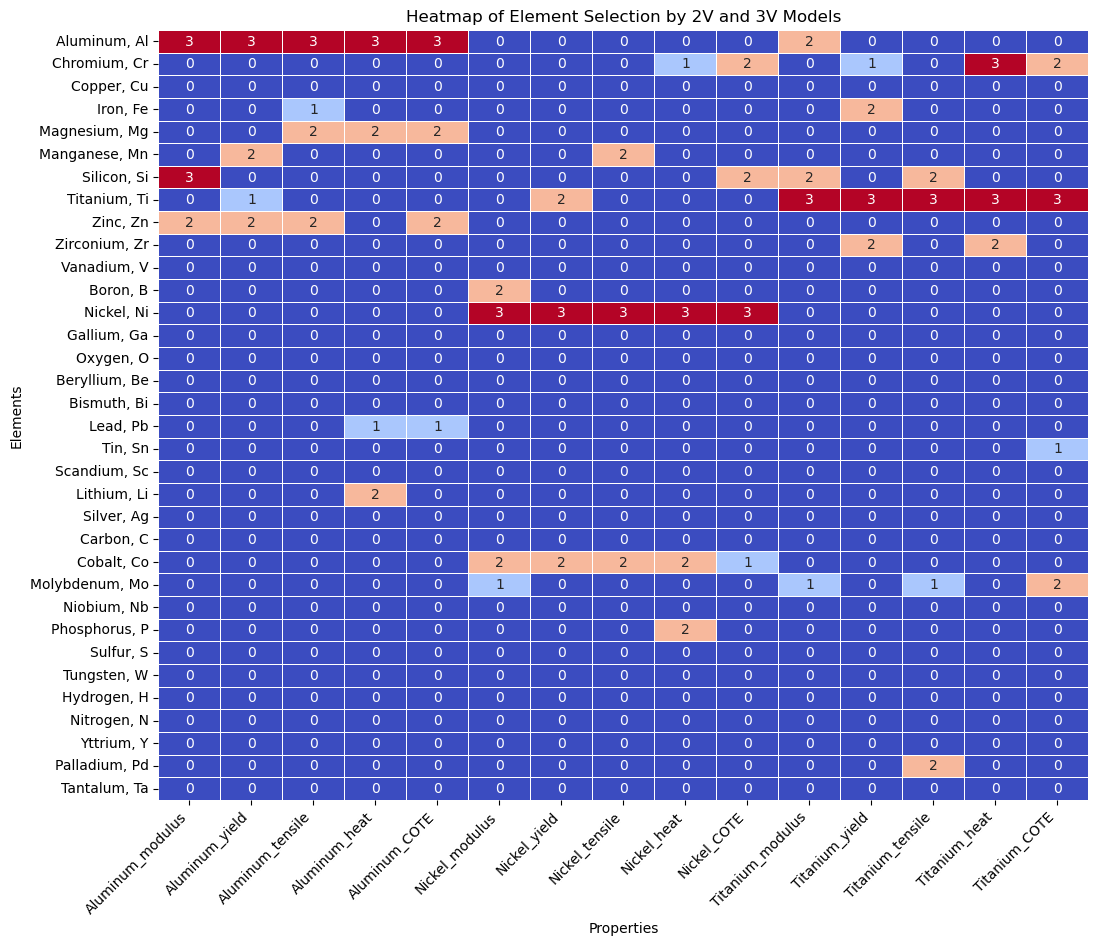

In [44]:
plt.figure(figsize=(12, 10))
sns.heatmap(full_property_matrix, annot=True, cmap="coolwarm", fmt="d", linewidths=.5, cbar=False)
plt.title('Heatmap of Element Selection by 2V and 3V Models')
plt.xlabel('Properties')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Elements')
plt.show()

/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_83042/4157162106.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(properties, rotation=45)
/var/folders/23/prfh1l6n7pxb55snfqs3862m0000gn/T/ipykernel_83042/4157162106.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(properties, rotation=45)


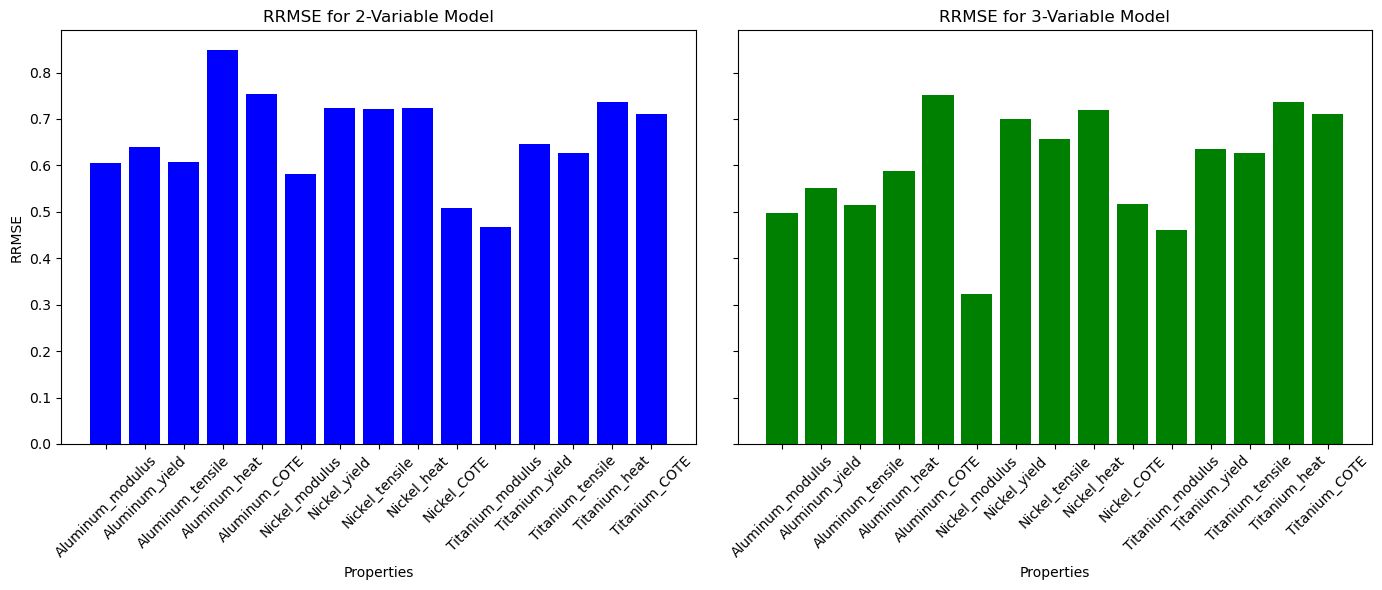

In [45]:
import matplotlib.pyplot as plt

# Compute RRMSE from MSE by taking the square root (as a simple approach to demonstrate)
# Typically RRMSE is relative to some benchmark which isn't provided, so we'll assume RRMSE = sqrt(MSE) for visualization
properties = list(best_combinations_2v.keys())
rrmse_2v = [best_combinations_2v[prop]['MSE']**0.5 for prop in properties]
rrmse_3v = [best_combinations_3v[prop]['MSE']**0.5 for prop in properties]

# Plotting the RRMSE for 2-variable and 3-variable models
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax[0].bar(properties, rrmse_2v, color='blue')
ax[0].set_title('RRMSE for 2-Variable Model')
ax[0].set_ylabel('RRMSE')
ax[0].set_xlabel('Properties')
ax[0].set_xticklabels(properties, rotation=45)

ax[1].bar(properties, rrmse_3v, color='green')
ax[1].set_title('RRMSE for 3-Variable Model')
ax[1].set_xlabel('Properties')
ax[1].set_xticklabels(properties, rotation=45)

plt.tight_layout()
plt.show()

In [46]:
# Function to extract numeric values (assuming the function needs to handle string or mixed data types)
def extract_numeric(x):
    try:
        return pd.to_numeric(x)
    except ValueError:
        return np.nan

# Update column name for consistency
df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"})

# Apply extract_numeric to the specified property columns
property_columns = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']
for col in property_columns:
    df[col] = df[col].apply(extract_numeric)

df.head()

Young's Modulus  Yield Strength  Tensile Strength  Specific Heat  \
654         0.222419       -0.003330         -0.011765       0.199970   
655        -0.642280        0.237168          0.303573       0.199970   
656         0.438593       -0.075479         -0.024904       0.507010   
657        -0.966541       -0.228797         -0.300824      -0.091338   
658         0.492637        0.718165          0.553215       0.199970   

     Coefficient of Thermal Expansion  Aluminum, Al  Chromium, Cr  Copper, Cu  \
654                          2.420703           3.4           0.0         0.0   
655                         -0.840015           3.0           0.0         0.0   
656                         -0.840015           0.0           0.0         0.0   
657                          0.693337           2.7           0.0         0.0   
658                          1.605523           3.0           0.0         0.0   

     Iron, Fe  Magnesium, Mg  ...  Molybdenum, Mo  Niobium, Nb  Phosphorus, P  \
654      1.60            0.0  ...             0.0          0.0            0.0   
655      2.00            0.0  ...             8.0          0.0            0.0   
656      0.35            0.0  ...            15.0          0.0            0.0   
657      0.20            0.0  ...             0.0          0.0            0.0   
658      0.00            0.0  ...             0.0          0.0            0.0   

     Sulfur, S  Tungsten, W  Hydrogen, H  Nitrogen, N  Yttrium, Y  \
654       0.00          0.0        0.015         0.05       0.000   
655       0.01          0.0        0.015         0.00       0.000   
656       0.00          0.0        0.020         0.05       0.000   
657       0.00          0.0        0.015         0.05       0.005   
658       0.00          0.0        0.000         0.00       0.000   

     Palladium, Pd  Tantalum, Ta  
654            0.0           0.0  
655            0.0           0.0  
656            0.0           0.0  
657            0.0           0.0  
658            0.0           0.0  

[5 rows x 39 columns]

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor  # Make sure to import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
file_path = 'Combodf.csv'  # ensure this path is correct
df = pd.read_csv(file_path)
df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"})  # Rename for consistency

# Define the metals and property names
metals = ['Aluminum', 'Nickel', 'Titanium']
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Placeholder for storing results
feature_importance_dfs = []
rrmse_results = []
selected_features_summary = []

# Configuration for the MLPRegressor
best_layers = (8, 8)
best_max_iter = 4000

# Loop over each metal and property to train models and extract features
for metal in metals:
    for p_name in property_names:
        # Filter by metal type and drop the 'Density' column
        metal_df = df[df['Metal Type'] == metal].drop(['Metal Type', 'Density'], axis=1)

        # Ensure data is clean for model input
        metal_df = metal_df.dropna(subset=[p_name])

        # Features and target
        X = metal_df.drop(property_names, axis=1)
        y = metal_df[p_name]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random Forest Model for feature selection
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate feature importance and select top features
        feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
        sorted_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
        
        # Include metal specific feature if not in top features
        metal_column = metal + ', ' + metal[:2]
        if metal_column not in sorted_features['Feature'].values:
            metal_feature = feature_importances[feature_importances['Feature'] == metal_column]
            sorted_features = pd.concat([sorted_features.head(9), metal_feature])
        
        # Keep the features for the bagging model
        selected_features = sorted_features['Feature'].values
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Bagging MLP model training
        best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
        best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
        best_bagging_model.fit(X_train_selected, y_train)
        best_preds = best_bagging_model.predict(X_test_selected)

        # Calculate RRMSE
        rrmse = np.sqrt(mean_squared_error(y_test, best_preds)) / np.sqrt(np.mean((y_test - np.mean(y_train)) ** 2))
        
        # Store results
        rrmse_results.append({'Metal': metal, 'Property': p_name, 'RRMSE': rrmse})
        feature_importance_dfs.append(sorted_features)
        selected_features_summary.append({'Metal': metal, 'Property': p_name, 'Features': ', '.join(selected_features)})
        

# Display RRMSE results
print(rrmse_results)

[{'Metal': 'Aluminum', 'Property': "Young's Modulus", 'RRMSE': 0.688257018109313}, {'Metal': 'Aluminum', 'Property': 'Yield Strength', 'RRMSE': 0.7887840065660696}, {'Metal': 'Aluminum', 'Property': 'Tensile Strength', 'RRMSE': 0.7198301997238513}, {'Metal': 'Aluminum', 'Property': 'Specific Heat', 'RRMSE': 0.7849058841231714}, {'Metal': 'Aluminum', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 1.005051820616094}, {'Metal': 'Nickel', 'Property': "Young's Modulus", 'RRMSE': 0.867102200023852}, {'Metal': 'Nickel', 'Property': 'Yield Strength', 'RRMSE': 1.0851634729299375}, {'Metal': 'Nickel', 'Property': 'Tensile Strength', 'RRMSE': 0.7832196657770482}, {'Metal': 'Nickel', 'Property': 'Specific Heat', 'RRMSE': 0.7657573402338508}, {'Metal': 'Nickel', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 0.8060672092754948}, {'Metal': 'Titanium', 'Property': "Young's Modulus", 'RRMSE': 0.9926526577834397}, {'Metal': 'Titanium', 'Property': 'Yield Strength', 'RRMSE': 0.937972

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
file_path = 'Combodf.csv'  # ensure this path is correct
df = pd.read_csv(file_path)
df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"})  # Rename for consistency

# Define the metals and property names
metals = ['Aluminum', 'Nickel', 'Titanium']
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Configuration for the MLPRegressor
best_layers = [(20, 5), (20, 5), (20, 5), (20, 5), (20, 5), (20, 5), (8,), (20, 5), (20, 5), (5, 5), (8, 8), (5, 5), (8,), (10,10), (8,8)]
best_max_iter = 4000

# Placeholder for storing results
feature_importance_dfs = []
rrmse_results = []
selected_features_summary = []

# Ensure the length of best_layers matches the number of iterations
assert len(best_layers) == len(metals) * len(property_names)

# Counter for iterating through best_layers
layer_idx = 0

# Loop over each metal and property to train models and extract features
for metal in metals:
    for p_name in property_names:
        # Filter by metal type and drop the 'Density' column
        metal_df = df[df['Metal Type'] == metal].drop(['Metal Type', 'Density'], axis=1)

        # Ensure data is clean for model input
        metal_df = metal_df.dropna(subset=[p_name])

        # Features and target
        X = metal_df.drop(property_names, axis=1)
        y = metal_df[p_name]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random Forest Model for feature selection
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate feature importance and select top features
        feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
        sorted_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
        
        # Include metal specific feature if not in top features
        metal_column = metal + ', ' + metal[:2]
        if metal_column not in sorted_features['Feature'].values:
            metal_feature = feature_importances[feature_importances['Feature'] == metal_column]
            sorted_features = pd.concat([sorted_features.head(9), metal_feature])
        
        # Keep the features for the bagging model
        selected_features = sorted_features['Feature'].values
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Use the corresponding MLP configuration
        current_layers = best_layers[layer_idx]
        layer_idx += 1

        # Bagging MLP model training
        best_base_nn = MLPRegressor(hidden_layer_sizes=current_layers, activation='relu', solver='adam', max_iter=best_max_iter)
        best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
        best_bagging_model.fit(X_train_selected, y_train)
        best_preds = best_bagging_model.predict(X_test_selected)

        # Calculate RRMSE
        rrmse = np.sqrt(mean_squared_error(y_test, best_preds)) / np.sqrt(np.mean((y_test - np.mean(y_train)) ** 2))
        
        # Store results
        rrmse_results.append({'Metal': metal, 'Property': p_name, 'RRMSE': rrmse})
        feature_importance_dfs.append(sorted_features)
        selected_features_summary.append({'Metal': metal, 'Property': p_name, 'Features': ', '.join(selected_features)})
        

# Display RRMSE results
print(rrmse_results)


[{'Metal': 'Aluminum', 'Property': "Young's Modulus", 'RRMSE': 0.6474237304632238}, {'Metal': 'Aluminum', 'Property': 'Yield Strength', 'RRMSE': 0.8090816222489287}, {'Metal': 'Aluminum', 'Property': 'Tensile Strength', 'RRMSE': 0.7367756921291937}, {'Metal': 'Aluminum', 'Property': 'Specific Heat', 'RRMSE': 0.8187012522935198}, {'Metal': 'Aluminum', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 1.009345270610996}, {'Metal': 'Nickel', 'Property': "Young's Modulus", 'RRMSE': 0.7975982004439552}, {'Metal': 'Nickel', 'Property': 'Yield Strength', 'RRMSE': 1.0696539203292563}, {'Metal': 'Nickel', 'Property': 'Tensile Strength', 'RRMSE': 1.2378425375604094}, {'Metal': 'Nickel', 'Property': 'Specific Heat', 'RRMSE': 0.89393024527502}, {'Metal': 'Nickel', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 1.0492198908418469}, {'Metal': 'Titanium', 'Property': "Young's Modulus", 'RRMSE': 0.9926526577834397}, {'Metal': 'Titanium', 'Property': 'Yield Strength', 'RRMSE': 0.998113

In [49]:
# Display selected features for each property
print(selected_features_summary)

[{'Metal': 'Aluminum', 'Property': "Young's Modulus", 'Features': 'Aluminum, Al, Silicon, Si, Zinc, Zn, Copper, Cu, Magnesium, Mg, Lithium, Li, Iron, Fe, Manganese, Mn, Titanium, Ti, Nickel, Ni'}, {'Metal': 'Aluminum', 'Property': 'Yield Strength', 'Features': 'Copper, Cu, Zinc, Zn, Magnesium, Mg, Aluminum, Al, Iron, Fe, Titanium, Ti, Manganese, Mn, Silicon, Si, Chromium, Cr, Bismuth, Bi'}, {'Metal': 'Aluminum', 'Property': 'Tensile Strength', 'Features': 'Copper, Cu, Magnesium, Mg, Aluminum, Al, Zinc, Zn, Titanium, Ti, Silicon, Si, Iron, Fe, Manganese, Mn, Chromium, Cr, Nickel, Ni'}, {'Metal': 'Aluminum', 'Property': 'Specific Heat', 'Features': 'Lithium, Li, Titanium, Ti, Silicon, Si, Zinc, Zn, Copper, Cu, Aluminum, Al, Tin, Sn, Manganese, Mn, Magnesium, Mg, Silver, Ag'}, {'Metal': 'Aluminum', 'Property': 'Coefficient of Thermal Expansion', 'Features': 'Aluminum, Al, Copper, Cu, Magnesium, Mg, Silicon, Si, Iron, Fe, Manganese, Mn, Zirconium, Zr, Gallium, Ga, Zinc, Zn, Titanium, Ti'},

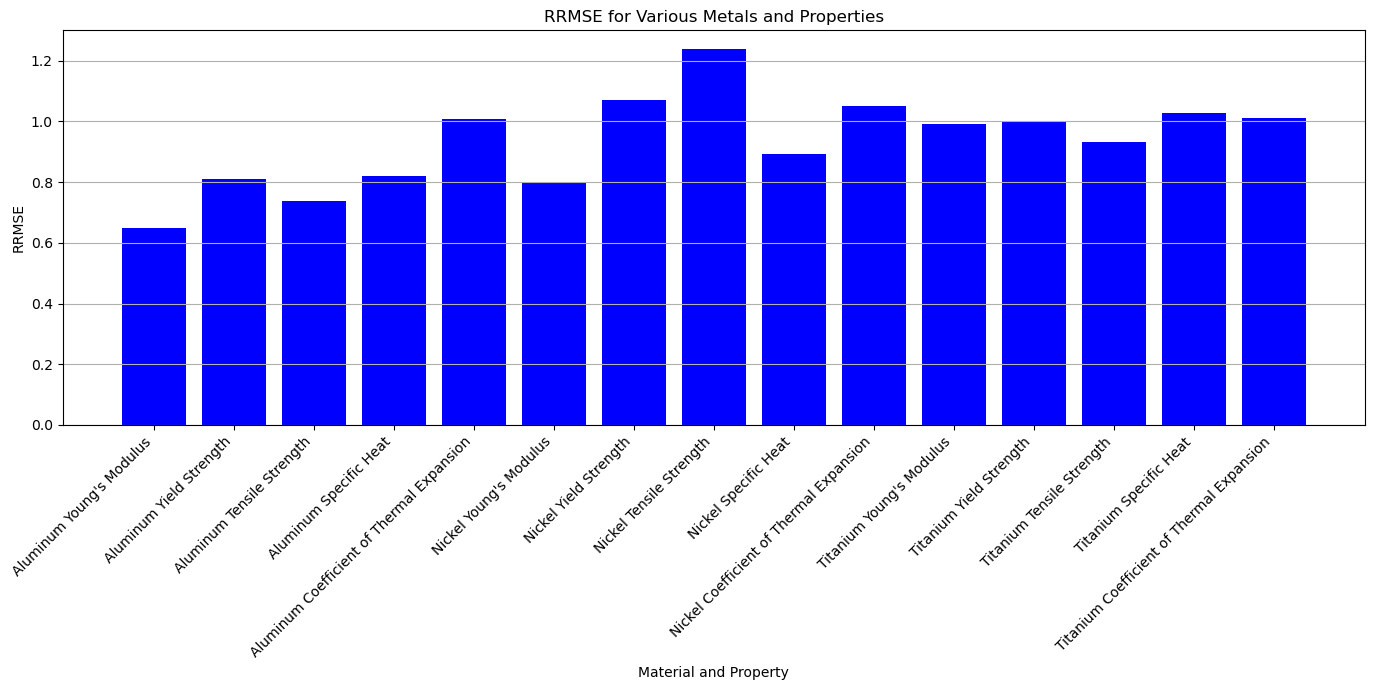

In [50]:
import matplotlib.pyplot as plt

# Create a DataFrame from the RRMSE results
rrmse_df = pd.DataFrame(rrmse_results)

# Prepare plot data
rrmse_df['Label'] = rrmse_df['Metal'] + ' ' + rrmse_df['Property']
rrmse_values = rrmse_df['RRMSE']
labels = rrmse_df['Label']

# Creating the bar chart
plt.figure(figsize=(14, 7))
plt.bar(labels, rrmse_values, color='blue')
plt.xlabel('Material and Property')
plt.ylabel('RRMSE')
plt.title('RRMSE for Various Metals and Properties')
plt.xticks(rotation=45, ha='right')  # Rotate labels to avoid overlap
plt.grid(axis='y') 
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


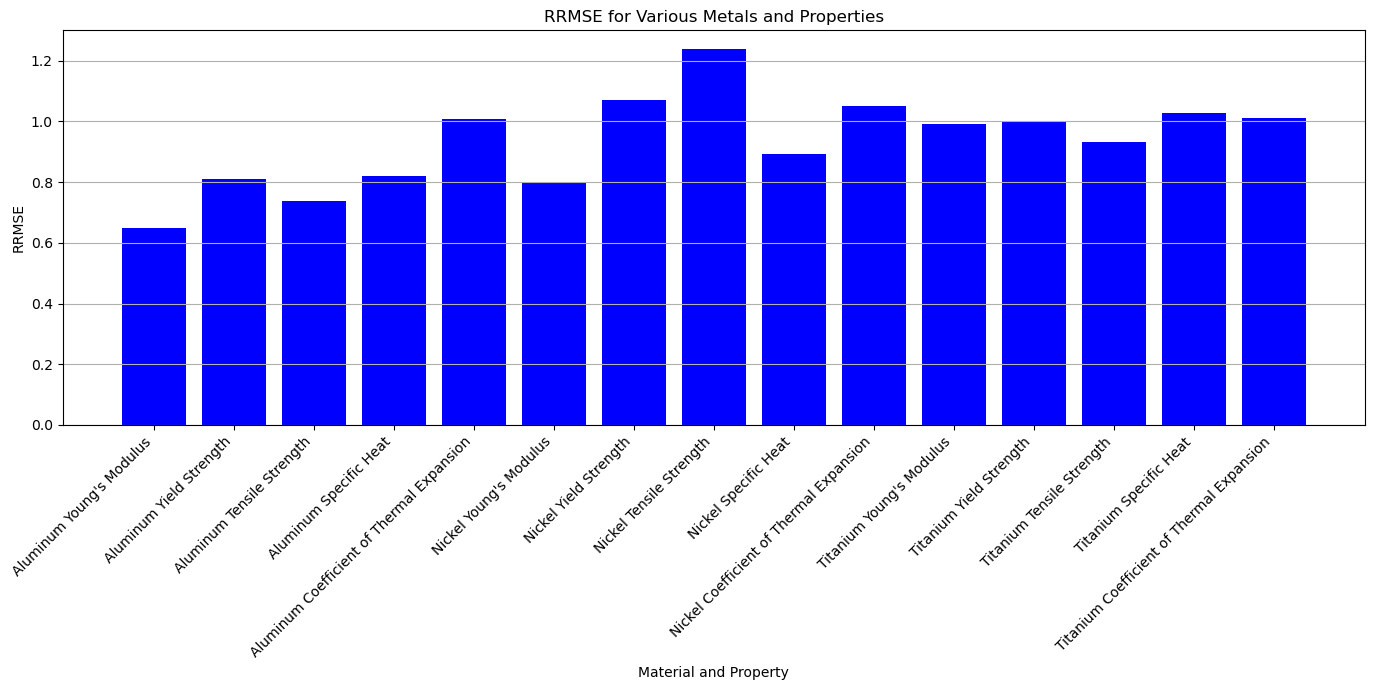

In [51]:
import matplotlib.pyplot as plt

# Create a DataFrame from the RRMSE results
rrmse_df = pd.DataFrame(rrmse_results)

# Prepare plot data
rrmse_df['Label'] = rrmse_df['Metal'] + ' ' + rrmse_df['Property']
rrmse_values = rrmse_df['RRMSE']
labels = rrmse_df['Label']

# Creating the bar chart
plt.figure(figsize=(14, 7))
plt.bar(labels, rrmse_values, color='blue')
plt.xlabel('Material and Property')
plt.ylabel('RRMSE')
plt.title('RRMSE for Various Metals and Properties')
plt.xticks(rotation=45, ha='right')  # Rotate labels to avoid overlap
plt.grid(axis='y') 
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib 
import os

# Load the data
file_path = 'Combodf.csv'  # ensure this path is correct
df = pd.read_csv(file_path)
df = df.rename(columns={"Niobium, Nb (Columbium, Cb)": "Niobium, Nb"})  # Rename for consistency

# Define the metals and property names
metals = ['Aluminum', 'Nickel', 'Titanium']
property_names = ['Young\'s Modulus', 'Yield Strength', 'Tensile Strength', 'Specific Heat', 'Coefficient of Thermal Expansion']

# Placeholder for storing results and models
feature_importance_dfs = []
rrmse_results = []
selected_features_summary = []
models = {}  # Dictionary to store models

# Configuration for the MLPRegressor
best_layers = (8, 8)
best_max_iter = 4000

# Loop over each metal and property to train models and extract features
for metal in metals:
    for p_name in property_names:
        # Filter by metal type and drop the 'Density' column
        metal_df = df[df['Metal Type'] == metal].drop(['Metal Type', 'Density'], axis=1)

        # Ensure data is clean for model input
        metal_df = metal_df.dropna(subset=[p_name])

        # Features and target
        X = metal_df.drop(property_names, axis=1)
        y = metal_df[p_name]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random Forest Model for feature selection
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate feature importance and select top features
        feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
        sorted_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)
        
        # Include metal specific feature if not in top features
        metal_column = metal + ', ' + metal[:2]
        if metal_column not in sorted_features['Feature'].values:
            metal_feature = feature_importances[feature_importances['Feature'] == metal_column]
            sorted_features = pd.concat([sorted_features.head(9), metal_feature])
        
        # Keep the features for the bagging model
        selected_features = sorted_features['Feature'].values
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Bagging MLP model training
        best_base_nn = MLPRegressor(hidden_layer_sizes=best_layers, activation='relu', solver='adam', max_iter=best_max_iter)
        best_bagging_model = BaggingRegressor(estimator=best_base_nn, n_estimators=10, random_state=42)
        best_bagging_model.fit(X_train_selected, y_train)
        models[(metal, p_name)] = best_bagging_model  # Store the trained model
        
        # Calculate RRMSE
        best_preds = best_bagging_model.predict(X_test_selected)
        rrmse = np.sqrt(mean_squared_error(y_test, best_preds)) / np.sqrt(np.mean((y_test - np.mean(y_train)) ** 2))
        
        # Store results
        rrmse_results.append({'Metal': metal, 'Property': p_name, 'RRMSE': rrmse})
        feature_importance_dfs.append(sorted_features)
        selected_features_summary.append({'Metal': metal, 'Property': p_name, 'Features': ', '.join(selected_features)})
        
# Optionally save models to disk
for key, model in models.items():
    # Define the directory and filename
    directory = "models"
    filename = f"{key[0]}_{key[1].replace(' ', '_')}_model.pkl"
    model_path = os.path.join(directory, filename)
    
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)
    
    # Save the model
    joblib.dump(model, model_path)

# Display RRMSE results
print(rrmse_results)

[{'Metal': 'Aluminum', 'Property': "Young's Modulus", 'RRMSE': 0.688257018109313}, {'Metal': 'Aluminum', 'Property': 'Yield Strength', 'RRMSE': 0.7887840065660696}, {'Metal': 'Aluminum', 'Property': 'Tensile Strength', 'RRMSE': 0.7198301997238513}, {'Metal': 'Aluminum', 'Property': 'Specific Heat', 'RRMSE': 0.7849058841231714}, {'Metal': 'Aluminum', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 1.005051820616094}, {'Metal': 'Nickel', 'Property': "Young's Modulus", 'RRMSE': 0.867102200023852}, {'Metal': 'Nickel', 'Property': 'Yield Strength', 'RRMSE': 1.0851634729299375}, {'Metal': 'Nickel', 'Property': 'Tensile Strength', 'RRMSE': 0.7832196657770482}, {'Metal': 'Nickel', 'Property': 'Specific Heat', 'RRMSE': 0.7657573402338508}, {'Metal': 'Nickel', 'Property': 'Coefficient of Thermal Expansion', 'RRMSE': 0.8060672092754948}, {'Metal': 'Titanium', 'Property': "Young's Modulus", 'RRMSE': 0.9926526577834397}, {'Metal': 'Titanium', 'Property': 'Yield Strength', 'RRMSE': 0.937972

In [153]:
def objective_function(composition, model, X_columns):
    """
    Objective function to optimize.
    Predicts the property value based on the given model and composition,
    and adjusts the score by considering the diversity of the components.

    Parameters:
        composition (list): Current guess for the metal composition percentages.
        model (sklearn model): Trained model to predict the property.
        X_columns (list): Names of the elements or components used in the model.

    Returns:
        float: Negated adjusted score to be minimized.
    """
    # Convert the composition list to a DataFrame with appropriate column names
    composition_df = pd.DataFrame([composition], columns=X_columns)
    
    # Predict the property value for the given composition
    predicted_value = model.predict(composition_df).flatten()[0]
    
    # Calculate the diversity penalty as the variance of component proportions, excluding the first
    diversity_penalty = np.var(composition[1:])  # Simplified to just the variance

    # Calculate the final adjusted score (negative for maximization in minimize function)
    adjusted_score = predicted_value - diversity_penalty

    # Return the negated adjusted score (because scipy.optimize.minimize seeks to minimize the function)
    return -adjusted_score


In [182]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor

# Assuming 'models' dictionary is properly defined with (metal, property) keys
# Assuming 'metals', 'property_names', and 'df' variables are properly set up

def objective_function(composition, model, X_columns):
    composition_df = pd.DataFrame([composition], columns=X_columns)
    predicted_value = model.predict(composition_df).flatten()[0]
    return -predicted_value

def optimize_alloy_composition(X_train, target_property, metal="Aluminum"):
    model = models[(metal, target_property)]
    X_columns = X_train.columns

    bounds = []
    initial_composition = []

    # Determine initial percentages
    for col in X_columns:
        if col.startswith(metal):
            bounds.append((75, 100))  # Primary metal between 75% and 100%
            initial_composition.append(90)  # Start from 90% for primary metal
        else:
            bounds.append((0, 25))  # Up to 25% for secondary elements
            initial_composition.append(1)  # Initialize with small but non-zero

    # Normalize secondary elements so their total is exactly the difference to 100%
    primary_metal_index = next(i for i, col in enumerate(X_columns) if col.startswith(metal))
    primary_metal_percentage = initial_composition[primary_metal_index]
    total_other_needed = 100 - primary_metal_percentage

    total_other_current = sum(initial_composition) - primary_metal_percentage
    if total_other_current == 0:  # Avoid division by zero if all are zero initially
        initial_composition = [primary_metal_percentage] + [total_other_needed / (len(X_columns) - 1)] * (len(X_columns) - 1)
    else:
        scaling_factor = total_other_needed / total_other_current
        for i in range(len(initial_composition)):
            if i != primary_metal_index:
                initial_composition[i] *= scaling_factor

    # Constraint for sum to 100%
    cons = [{'type': 'eq', 'fun': lambda x: 100 - np.sum(x)}]

    best_score = float('-inf')
    best_composition = None

    for _ in range(25):  # Run optimization multiple times
        result = minimize(
            objective_function,
            initial_composition,
            args=(model, X_columns),
            method='SLSQP',
            bounds=bounds,
            constraints=cons
        )

        if result.success and -result.fun > best_score:
            best_score = -result.fun
            best_composition = result.x

    # Map back the composition percentages to metal names
    metal_composition = dict(zip(X_columns, best_composition))

    return metal_composition, best_score


# Collecting and processing results
results = []
for metal in metals:
    for p_name in property_names:
        feature_df = feature_importance_dfs[metals.index(metal) * len(property_names) + property_names.index(p_name)]
        important_features = feature_df.sort_values(by='Importance', ascending=False)['Feature'].tolist()
        X_train = df[important_features].dropna(axis=1)  # Simulated train data

        try:
            composition, score = optimize_alloy_composition(X_train, p_name, metal)
            results.append({'Metal': metal, 'Property': p_name, 'Score': score, 'Composition': composition})
            print(f"Optimized composition for {metal} {p_name}: Score = {score}, Composition = {composition}")
        except Exception as e:
            print(f"Error optimizing composition for {metal} {p_name}: {e}")

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results)

Optimized composition for Aluminum Young's Modulus: Score = 9.57204497850072, Composition = {'Aluminum, Al': 75.0, 'Silicon, Si': 1.2212453270876722e-15, 'Zinc, Zn': 0.0, 'Copper, Cu': 0.0, 'Magnesium, Mg': 6.217248937900877e-15, 'Lithium, Li': 25.0, 'Iron, Fe': 0.0, 'Manganese, Mn': 0.0, 'Titanium, Ti': 0.0, 'Nickel, Ni': 0.0}
Optimized composition for Aluminum Yield Strength: Score = 8.518386378651993, Composition = {'Copper, Cu': 1.8346435481930712e-14, 'Zinc, Zn': 3.760880495917718e-15, 'Magnesium, Mg': 0.0, 'Aluminum, Al': 75.0, 'Iron, Fe': 7.181755190543981e-16, 'Titanium, Ti': 8.222589276130066e-16, 'Manganese, Mn': 7.840950111415168e-16, 'Silicon, Si': 7.494005416219807e-16, 'Chromium, Cr': 0.0, 'Bismuth, Bi': 24.99999999999998}
Optimized composition for Aluminum Tensile Strength: Score = 3.015459735910489, Composition = {'Copper, Cu': 0.7209123292328213, 'Magnesium, Mg': 10.701896122988192, 'Aluminum, Al': 75.00000000000016, 'Zinc, Zn': 13.577191547799671, 'Titanium, Ti': 1.09

In [183]:
results_df

Metal                          Property      Score  \
0   Aluminum                   Young's Modulus   9.572045   
1   Aluminum                    Yield Strength   8.518386   
2   Aluminum                  Tensile Strength   3.015460   
3   Aluminum                     Specific Heat   6.742148   
4   Aluminum  Coefficient of Thermal Expansion   1.651099   
5     Nickel                   Young's Modulus   2.456301   
6     Nickel                    Yield Strength   2.021268   
7     Nickel                  Tensile Strength   1.814711   
8     Nickel                     Specific Heat   1.730179   
9     Nickel  Coefficient of Thermal Expansion   2.245085   
10  Titanium                   Young's Modulus   1.867729   
11  Titanium                    Yield Strength   1.771514   
12  Titanium                  Tensile Strength   0.874626   
13  Titanium                     Specific Heat  22.267846   
14  Titanium  Coefficient of Thermal Expansion   1.633688   

                                          Composition  
0   {'Aluminum, Al': 75.0, 'Silicon, Si': 1.221245...  
1   {'Copper, Cu': 1.8346435481930712e-14, 'Zinc, ...  
2   {'Copper, Cu': 0.7209123292328213, 'Magnesium,...  
3   {'Lithium, Li': 2.222387471865648, 'Titanium, ...  
4   {'Aluminum, Al': 75.0, 'Copper, Cu': 1.7289101...  
5   {'Titanium, Ti': 5.804818434224768e-16, 'Carbo...  
6   {'Nickel, Ni': 75.0, 'Boron, B': 23.6361474282...  
7   {'Nickel, Ni': 75.00000000000003, 'Molybdenum,...  
8   {'Molybdenum, Mo': 1.333378650914685e-16, 'Nic...  
9   {'Chromium, Cr': 4.500280322167009e-16, 'Titan...  
10  {'Palladium, Pd': 0.0, 'Copper, Cu': 4.0138112...  
11  {'Titanium, Ti': 75.0000000000003, 'Aluminum, ...  
12  {'Titanium, Ti': 75.0, 'Tantalum, Ta': 3.46951...  
13  {'Bismuth, Bi': 25.0, 'Palladium, Pd': 0.0, 'H...  
14  {'Aluminum, Al': 7.294336108602643e-16, 'Tin, ...

In [184]:
# Extracting and expanding the composition into separate columns
composition_df = results_df['Composition'].apply(pd.Series)

# Merge the expanded composition dataframe with the metal and property
expanded_df = results_df[['Metal', 'Property']].join(composition_df).fillna(0)

# Creating a MultiIndex for columns combining Metal and Property
expanded_df.set_index(['Metal', 'Property'], inplace=True)

# Transposing the dataframe to have metals and properties as columns and elements as rows
matrix_composition_df = expanded_df.T

matrix_composition_df

Metal                 Aluminum                                                \
Property       Young's Modulus Yield Strength Tensile Strength Specific Heat   
Aluminum, Al      7.500000e+01   7.500000e+01     7.500000e+01  7.500000e+01   
Silicon, Si       1.221245e-15   7.494005e-16     4.487880e-13  8.283412e-15   
Zinc, Zn          0.000000e+00   3.760880e-15     1.357719e+01  1.178861e-14   
Copper, Cu        0.000000e+00   1.834644e-14     7.209123e-01  8.926032e-15   
Magnesium, Mg     6.217249e-15   0.000000e+00     1.070190e+01  2.487503e-16   
Lithium, Li       2.500000e+01   0.000000e+00     0.000000e+00  2.222387e+00   
Iron, Fe          0.000000e+00   7.181755e-16     5.718202e-14  0.000000e+00   
Manganese, Mn     0.000000e+00   7.840950e-16     2.094729e-12  1.583112e-14   
Titanium, Ti      0.000000e+00   8.222589e-16     1.097228e-13  2.277761e+01   
Nickel, Ni        0.000000e+00   0.000000e+00     3.140492e-12  0.000000e+00   
Chromium, Cr      0.000000e+00   0.000000e+00     2.519669e-12  0.000000e+00   
Bismuth, Bi       0.000000e+00   2.500000e+01     0.000000e+00  0.000000e+00   
Tin, Sn           0.000000e+00   0.000000e+00     0.000000e+00  9.037650e-15   
Silver, Ag        0.000000e+00   0.000000e+00     0.000000e+00  1.193549e-07   
Zirconium, Zr     0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Gallium, Ga       0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Carbon, C         0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Boron, B          0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Cobalt, Co        0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Sulfur, S         0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Molybdenum, Mo    0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Phosphorus, P     0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Niobium, Nb       0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Palladium, Pd     0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Vanadium, V       0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Oxygen, O         0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Hydrogen, H       0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   
Tantalum, Ta      0.000000e+00   0.000000e+00     0.000000e+00  0.000000e+00   

Metal                                                    Nickel  \
Property       Coefficient of Thermal Expansion Young's Modulus   
Aluminum, Al                       7.500000e+01    8.042047e-17   
Silicon, Si                        1.538456e-16    1.702986e+00   
Zinc, Zn                           1.107636e+01    0.000000e+00   
Copper, Cu                         1.728910e-16    0.000000e+00   
Magnesium, Mg                      4.834405e-16    0.000000e+00   
Lithium, Li                        0.000000e+00    0.000000e+00   
Iron, Fe                           5.051488e+00    8.958009e-17   
Manganese, Mn                      2.097555e-17    0.000000e+00   
Titanium, Ti                       0.000000e+00    5.804818e-16   
Nickel, Ni                         0.000000e+00    7.500000e+01   
Chromium, Cr                       0.000000e+00    6.036324e-18   
Bismuth, Bi                        0.000000e+00    0.000000e+00   
Tin, Sn                            0.000000e+00    0.000000e+00   
Silver, Ag                         0.000000e+00    0.000000e+00   
Zirconium, Zr                      8.872156e+00    0.000000e+00   
Gallium, Ga                        0.000000e+00    0.000000e+00   
Carbon, C                          0.000000e+00    2.202361e-16   
Boron, B                           0.000000e+00    2.329701e+01   
Cobalt, Co                         0.000000e+00    4.411563e-16   
Sulfur, S                          0.000000e+00    1.762596e-16   
Molybdenum, Mo                     0.000000e+00    0.000000e+00   
Phosphorus, P                      0.000000e+00    0.00000

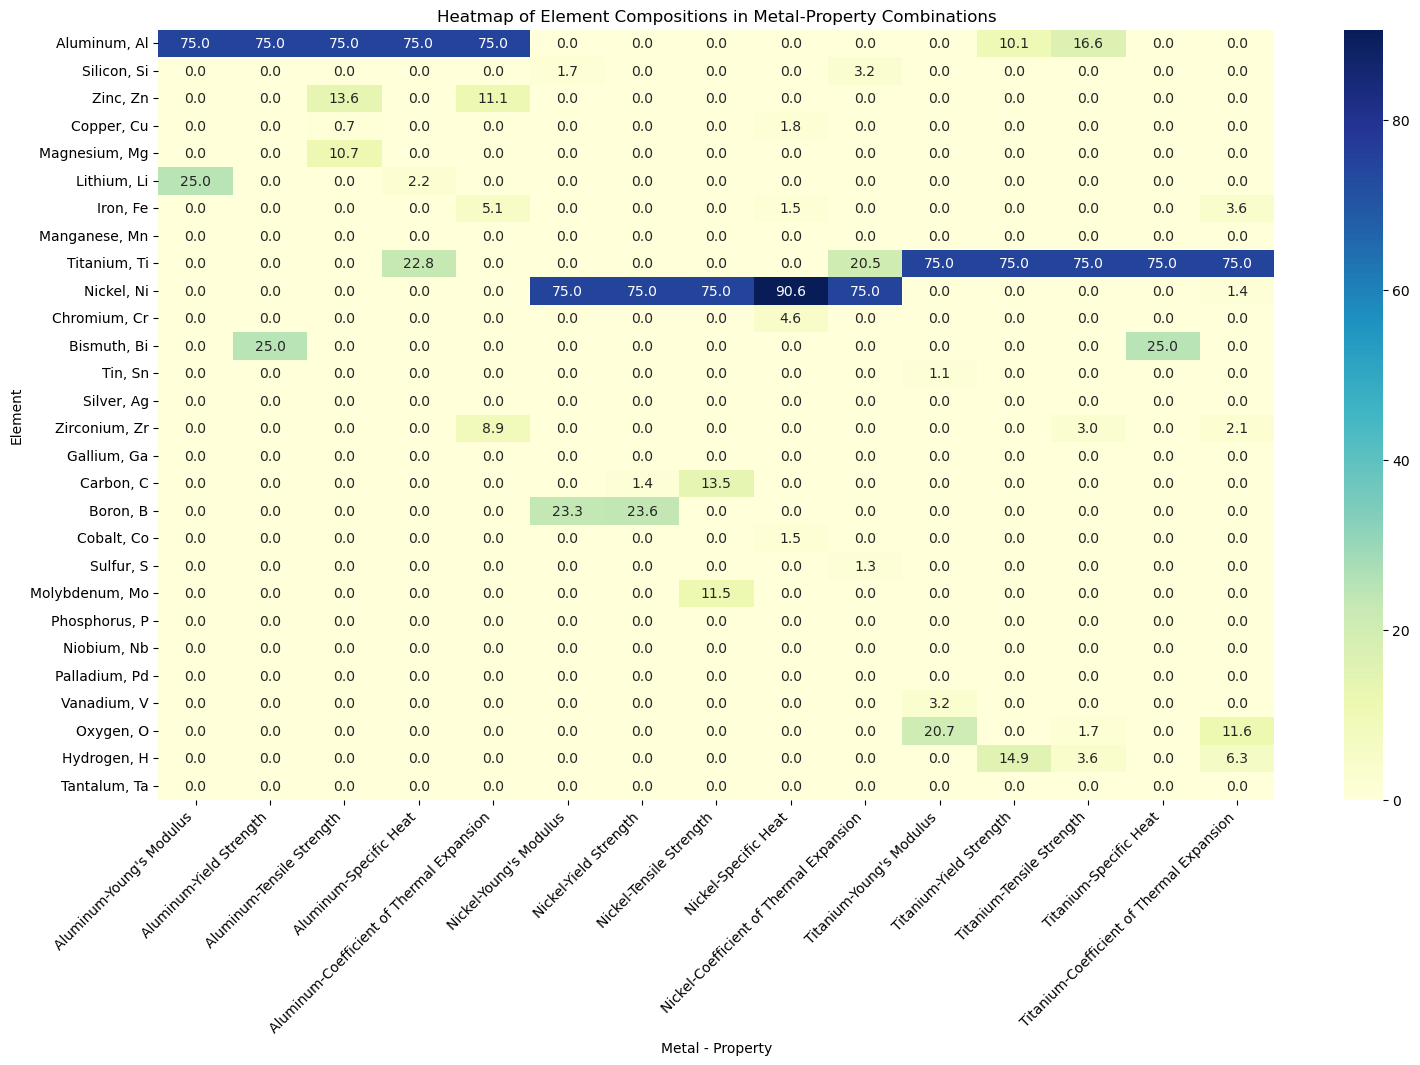

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a heatmap of the composition matrix
plt.figure(figsize=(18, 10))
sns.heatmap(matrix_composition_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Heatmap of Element Compositions in Metal-Property Combinations")
plt.xlabel("Metal - Property")
plt.ylabel("Element")
plt.xticks(rotation=45, ha='right')
plt.show()


In [180]:
print(feature_importance_dfs)

[          Feature  Importance
0    Aluminum, Al    0.638778
6     Silicon, Si    0.158509
8        Zinc, Zn    0.053139
2      Copper, Cu    0.042156
4   Magnesium, Mg    0.033172
20    Lithium, Li    0.024946
3        Iron, Fe    0.013154
5   Manganese, Mn    0.009813
7    Titanium, Ti    0.007446
12     Nickel, Ni    0.006321,           Feature  Importance
2      Copper, Cu    0.276014
8        Zinc, Zn    0.220882
4   Magnesium, Mg    0.156801
0    Aluminum, Al    0.092477
3        Iron, Fe    0.074384
7    Titanium, Ti    0.047543
5   Manganese, Mn    0.042880
6     Silicon, Si    0.040860
1    Chromium, Cr    0.022855
16    Bismuth, Bi    0.007745,           Feature  Importance
2      Copper, Cu    0.378416
4   Magnesium, Mg    0.172605
0    Aluminum, Al    0.114631
8        Zinc, Zn    0.105708
7    Titanium, Ti    0.081312
6     Silicon, Si    0.045713
3        Iron, Fe    0.045647
5   Manganese, Mn    0.020829
1    Chromium, Cr    0.016997
12     Nickel, Ni    0.005514,       

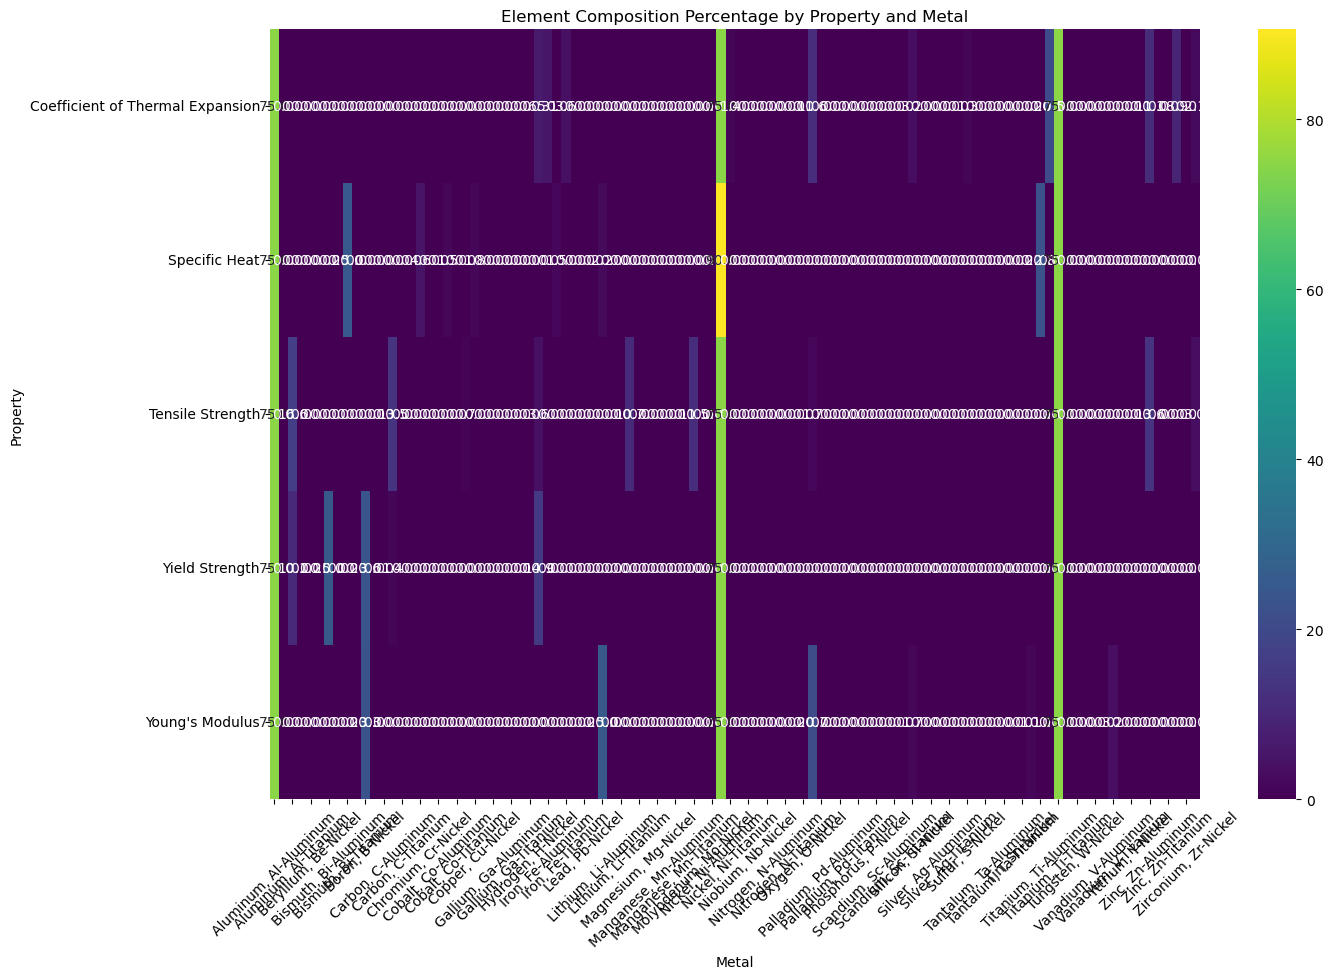

In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assume results_df is already defined and includes columns ['Metal', 'Property', 'Composition']

# Expand the Composition dictionary into rows
rows = []
for idx, row in results_df.iterrows():
    for element, percentage in row['Composition'].items():
        rows.append({'Metal': row['Metal'], 'Property': row['Property'], element: percentage})

# Create a new DataFrame
expanded_df = pd.DataFrame(rows)

# Fill missing values with 0 (for elements that are not part of some compositions)
expanded_df.fillna(0, inplace=True)

# Now we need to make sure we have all elements in the columns
for element in all_elements:
    if element not in expanded_df.columns:
        expanded_df[element] = 0.0

# Reshape the DataFrame for easier plotting
reshaped_df = pd.pivot_table(expanded_df, index='Property', columns='Metal', values=all_elements, aggfunc=np.sum)

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(reshaped_df, annot=True, cmap='viridis', fmt=".1f")
plt.title('Element Composition Percentage by Property and Metal')
plt.ylabel('Property')
plt.xlabel('Metal')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
